# Comparison of East River ASO and Nearby SNTL
--------------------------------
### Daniel Hogan
### University of Washington 
- SNOTEL data taken from NRCS using the sript get_east_river_sntl_data.py
- ASO data downloaded for 2016, 2018, 2019, and 2022 from NSIDC

In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from metloom.pointdata import SnotelPointData

import datetime as dt

import rioxarray as rioxr
import geopandas as gpd
import fiona 
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import contextily as cx

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot, mask

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/metloom/pointdata/base.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### All included setup code
- ER Polygon

In [2]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('./multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

### Pull in the SNOTEL data and Locations, then plot them on a map

In [3]:
er_sntl_data = xr.open_dataset('../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [4]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("680:CO:SNTL", "Park Cone")
park_cone_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_pass_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("1141:CO:SNTL", "Upper Taylor")
upper_taylor_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]


### Start building basemap

In [6]:
sntl_gdf = gpd.GeoSeries([butte_loc,park_cone_loc,schofield_pass_loc,upper_taylor_loc]).set_crs('4326')
sntl_gdf_local = sntl_gdf.to_crs(upper_east_river_poly.crs)

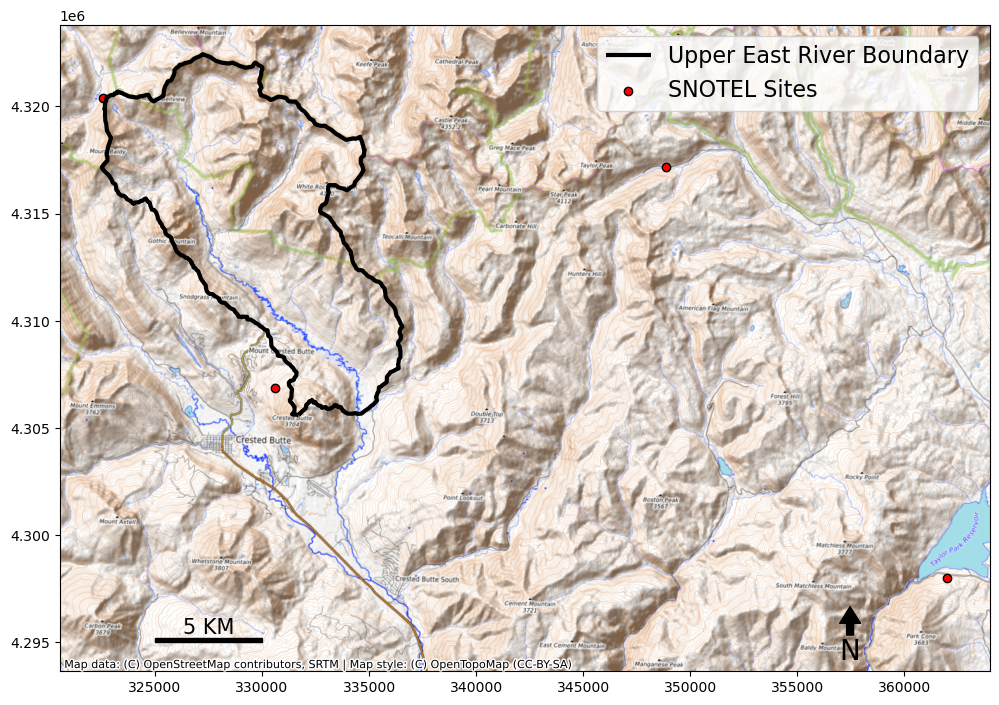

In [7]:
#Now making a basemap in contextily

ax = upper_east_river_poly.boundary.plot(color='k', linewidth=3, label='Upper East River Boundary', figsize=(12,12),edgecolor='k')

#Add north arrow, https://stackoverflow.com/a/58110049/604456
x, y, arrow_length = 0.85, 0.10, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# #Add scale-bar
x, y, scale_len = 325000, 4.295e6, 5000 #arrowstyle='-'
scale_rect = patches.Rectangle((x,y),scale_len,200,linewidth=1,edgecolor='k',facecolor='k')
ax.add_patch(scale_rect)
plt.text(x+scale_len/2, y+400, s='5 KM', fontsize=15, horizontalalignment='center')

#Add in hospitals as points
sntl_gdf_local.plot(c="r", alpha=1, ec='k', label='SNOTEL Sites', ax=ax)

#Now making a nice legend
ax.legend(loc='upper right', prop={'size': 16})

#Now adding in the basemap imagery
cx.add_basemap(ax, crs=upper_east_river_poly.crs.to_string(), source=cx.providers.OpenTopoMap)


### Get ASO files, load up and compute basin mean value

In [5]:
ASO_swe_files = glob.glob('/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/*.tif')

In [12]:
# unneded now -  rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
# skipping the CB area flight on 20180330 because there was another flight on march 30 over our specific basin
dates = [dt.date(2016,4,4), dt.date(2018,3,31),dt.date(2018,5,24),dt.date(2019,4,7),dt.date(2019,6,10),dt.date(2022,4,21)]

# create empty dictionaries to fill
aso_swe_mean_dict = {}
aso_swe_median_dict = {}
aso_swe_25th_dict = {}
aso_swe_75th_dict = {}
aso_swe_date_dict = dict(zip(ASO_swe_files, dates))

for i,file in enumerate(ASO_swe_files):
    if '20180330' in file:
        continue
    else:
        src_swe = rioxr.open_rasterio(file).squeeze()
        src_er_swe = src_swe.rio.clip(upper_east_river_poly.geometry)
        src_er_swe_ma = src_er_swe.where(src_er_swe>=0)
        
        # Save mean and standard deviation in centimeters
        aso_swe_mean_dict[file[:-4]] = src_er_swe_ma.mean().values * 100 # convert to centimeters
        aso_swe_median_dict[file[:-4]] = src_er_swe_ma.median().values * 100 # convert to centimeters
        aso_swe_25th_dict[file[:-4]] = src_er_swe_ma.quantile(0.25).values * 100 # convert to centimeters
        aso_swe_75th_dict[file[:-4]] = src_er_swe_ma.quantile(0.75).values * 100 # convert to centimeters
        del src_swe,src_er_swe,src_er_swe_ma

In [7]:
aso_stats_df = pd.DataFrame([aso_swe_date_dict.values(),aso_swe_mean_dict.values(), aso_swe_median_dict.values(), aso_swe_25th_dict.values(), aso_swe_75th_dict.values()]).T
aso_stats_df = aso_stats_df.rename(columns={0:'date',1:'mean', 2:'median', 3:'25th_quartile', 4:'75th_quartile'})
aso_stats_df = aso_stats_df.set_index('date')

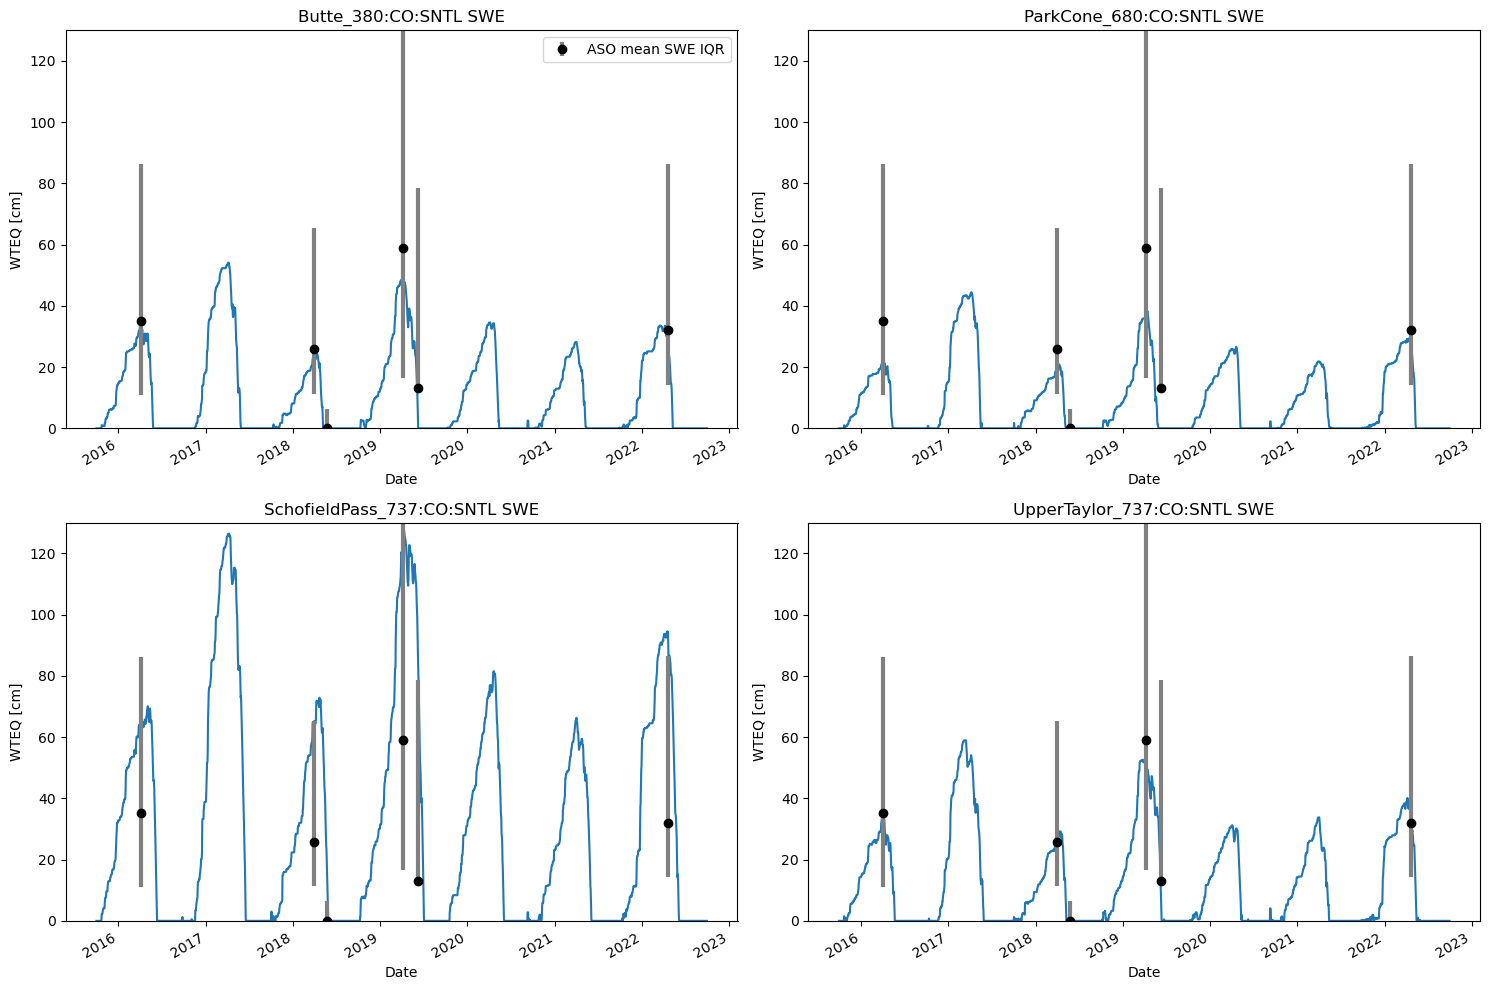

In [8]:
# Create a plot for a time series of each SNOTEL site from 2016 to 2022
er_sntl_2016_2022 = er_sntl_data.sel(Date=slice('2015-10-01','2022-09-30'))

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10), tight_layout=True)
axs=axs.ravel()
for i,loc in enumerate(er_sntl_2016_2022.Location):
    ax = axs[i]
    er_sntl_2016_2022.sel(Location=loc).WTEQ.plot(ax=ax)
    
    
    # ax.scatter(aso_stats_df.index, aso_stats_df['mean'], label='ASO mean SWE', color='red',)
    ax.errorbar(aso_stats_df.index, aso_stats_df['median'],yerr=[aso_stats_df['25th_quartile'],aso_stats_df['75th_quartile']], 
                fmt='o', 
                color='black',
                ecolor='gray', 
                elinewidth=3, 
                capsize=0,
                label='ASO mean SWE IQR');
    
    ax.set_title(f'{loc.values} SWE')
    ax.set_ylim(0,130)
    if i == 0:
        ax.legend()

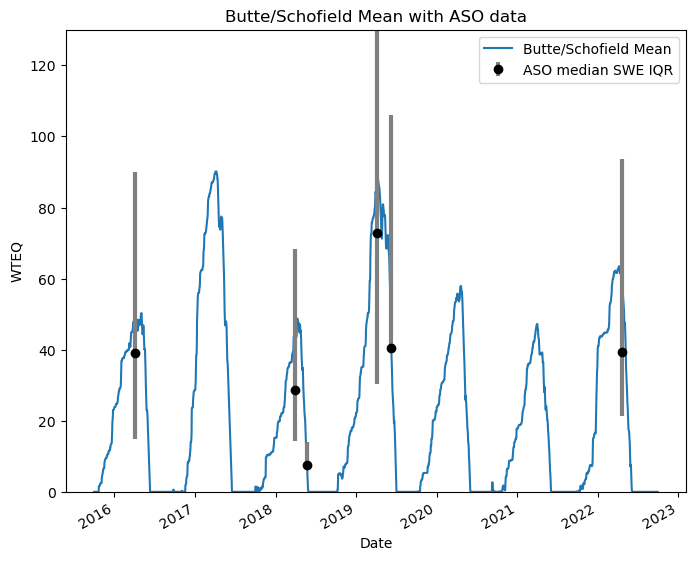

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
er_sntl_2016_2022.sel(Location=['Butte_380:CO:SNTL','SchofieldPass_737:CO:SNTL']).WTEQ.mean(dim='Location').plot(label='Butte/Schofield Mean')

ax.errorbar(aso_stats_df.index, aso_stats_df['mean'],yerr=[aso_stats_df['25th_quartile'],aso_stats_df['75th_quartile']], 
                fmt='o', 
                color='black',
                ecolor='gray', 
                elinewidth=3, 
                capsize=0,
                label='ASO median SWE IQR');

ax.set_ylim(0,130)
ax.set_title('Butte/Schofield Mean with ASO data')
ax.legend()

Butte/Schofield Mean - Mean RMSE = 8.73620348053819 cm
Butte - Mean RMSE = 3.086255150380417 cm
Schofield - Mean RMSE = 20.383741442851974 cm
Upper Taylor - Mean RMSE = 1.672448369713457 cm


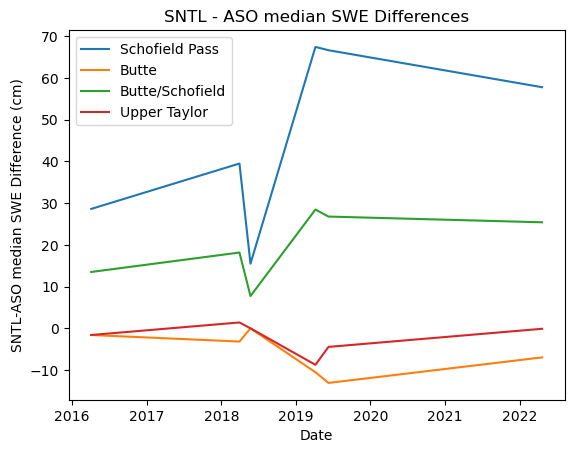

In [14]:
butte_schofield_mean_aso_overlap = er_sntl_2016_2022.sel(Date=dates,Location=['Butte_380:CO:SNTL','SchofieldPass_737:CO:SNTL']).WTEQ.mean(dim='Location')
butte_aso_overlap = er_sntl_2016_2022.sel(Date=dates,Location=['Butte_380:CO:SNTL']).WTEQ.mean(dim='Location')
schofield_aso_overlap = er_sntl_2016_2022.sel(Date=dates,Location=['SchofieldPass_737:CO:SNTL']).WTEQ.mean(dim='Location')
upper_taylor_aso_overlap = er_sntl_2016_2022.sel(Date=dates,Location=['UpperTaylor_737:CO:SNTL']).WTEQ.mean(dim='Location')


plt.plot(dates,(schofield_aso_overlap-aso_stats_df['median']),label='Schofield Pass')
plt.plot(dates,(butte_aso_overlap-aso_stats_df['median']),label='Butte')
plt.plot(dates,(butte_schofield_mean_aso_overlap-aso_stats_df['median']),label='Butte/Schofield')
plt.plot(dates, (upper_taylor_aso_overlap-aso_stats_df['median']), label='Upper Taylor')
plt.xlabel('Date')
plt.ylabel('SNTL-ASO median SWE Difference (cm)')
plt.title('SNTL - ASO median SWE Differences')
plt.legend()


labels = ['Butte/Schofield Mean','Butte','Schofield','Upper Taylor']
for i,site in enumerate([butte_schofield_mean_aso_overlap,butte_aso_overlap,schofield_aso_overlap,upper_taylor_aso_overlap]):
    rmse = np.sqrt((((site-aso_stats_df['median'])**2/len(dates)).values).mean())
    print(f'{labels[i]} - Mean RMSE = {rmse} cm')

### Butte-Schofield Mean is the closest to mean ASO flight values mean values, but Butte and Upper Taylor are best with respect to the median

# Visualize SWE if desired

In [ ]:
# fig, ax = plt.subplots(figsize=(10,20))

# # east_river_polygon.boundary.plot(ax=ax,label='East River Watershed', color='r', ls='--')
# cax = ax.imshow(src_ma_swe, extent=east_ma_extent, cmap='Blues', vmin=0, vmax=0.5)
# ax.set_title(f'March 31, 2018 SWE - Mean = {src_ma_swe.mean()} m')
# plt.colorbar(cax, label = 'SWE (m)', ax=ax, fraction=0.046, pad=0.04)